<a href="https://colab.research.google.com/github/jamil-wittmann/Wittmann_BIX_F21/blob/main/Homework2_accumulation_of_evidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 - Evidence Accumulation

This homework has two main parts:

- First, we will build off the lab by exploring the relationship between decision threshold (one of the DDM parameters) and the performance of an accumulating agent.
- Second, we will take a brief look at the role of randomness in the exploratory behavior of a sniffing agent.

## Section - Setup

### Install explorationlib, import modules, configure notebook

In [ ]:
# ADMCode uses an old version of numba
!pip install numba==0.48
!pip install --upgrade git+https://github.com/clappm/AdaptiveDecisionMaking_2018

!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs


from __future__ import division
from ADMCode import visualize as vis
from ADMCode import ddm, sdt

import numpy as np
import pandas as pd

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death

# Pretty plots
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 3.5 MB 7.0 MB/s 
     |████████████████████████████████| 20.2 MB 1.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Cloning https://github.com/clappm/AdaptiveDecisionMaking_2018 to /tmp/pip-req-build-pi_swymb
  Running command git clone -q https://github.com/clappm/AdaptiveDecisionMaking_2018 /tmp/pip-req-build-pi_swymb
  Created wheel for ADMCode: filename=ADMCode-0.5.2-py3-none-any.whl size=39223 sha256=f6903b3a563f2d7df2ff1234d85e169841d5aea7d534f847e8995e8ccc44fe51
  Stored in directory: /tmp/pip-ephem-wheel-cache-wlqbhsmk/wheels/39/45/1c/971b7fac68419e436447919c986b425b87e4ab1ed2d33d9fa4
Successfully built ADMCode
  Cloning https://github.com/parenthetical-e/explorationli

/usr/local/lib/python3.7/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


pygame 2.0.2 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Section - Influence of Threshold on Performance [60 pts total]

How does decision thershold influence behavior? Here, we will perform a parameter sweep over the decision threshold to see how the agent is affected in a basic sniffing task.

For this section, you will need to slightly modify the lab code to loop over a list of thresholds rather than a list of drift rates.

### Define shared parameters and initialize environment [5 pts]

In [ ]:
# Shared exp parameters
num_steps = 200
max_steps = 10
seed_value = 5838

min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 250 
target_boundary = (100, 100)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
coord, scent = create_grid_scent(target_boundary, amplitude=1, sigma=10)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Create a list of thresholds to test [5 pts]

Select at least 5 values.  For reference, the lab used a threshold of 3.

In [ ]:
# Our parameters 
thresholds = [0.01, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

# For plotting
colors = ["red", "orange", "green", "blue", "purple", "pink", "gray", "cyan", "brown"]
names = thresholds # list(range(8))


### Run 100 experiments for each threshold [10 pts]

Use a drift rate of 1.0, the middle value from the lab.

In [ ]:


# Exp params
drift_rate = 1.0
accumulate_sigma = 1.0

num_experiments = 100

# Run
results = []
for i, threshold in zip(names, thresholds):
    accum = AccumulatorGradientGrid(
        min_length=min_length, 
        max_steps=max_steps, 
        drift_rate=drift_rate, 
        threshold=threshold,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_0:   0%|          | 0/100 [00:00<?, ?it/s]

accum_0:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_2:   0%|          | 0/100 [00:00<?, ?it/s]

accum_2:   0%|          | 0/100 [00:00<?, ?it/s]

accum_3:   0%|          | 0/100 [00:00<?, ?it/s]

accum_3:   0%|          | 0/100 [00:00<?, ?it/s]

accum_4:   0%|          | 0/100 [00:00<?, ?it/s]

### Create plots of distance traveled, number of deaths, best score, and average score [10 pts]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

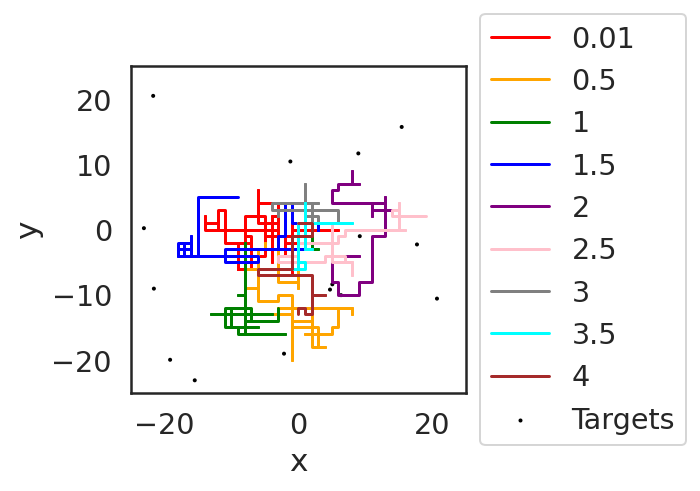

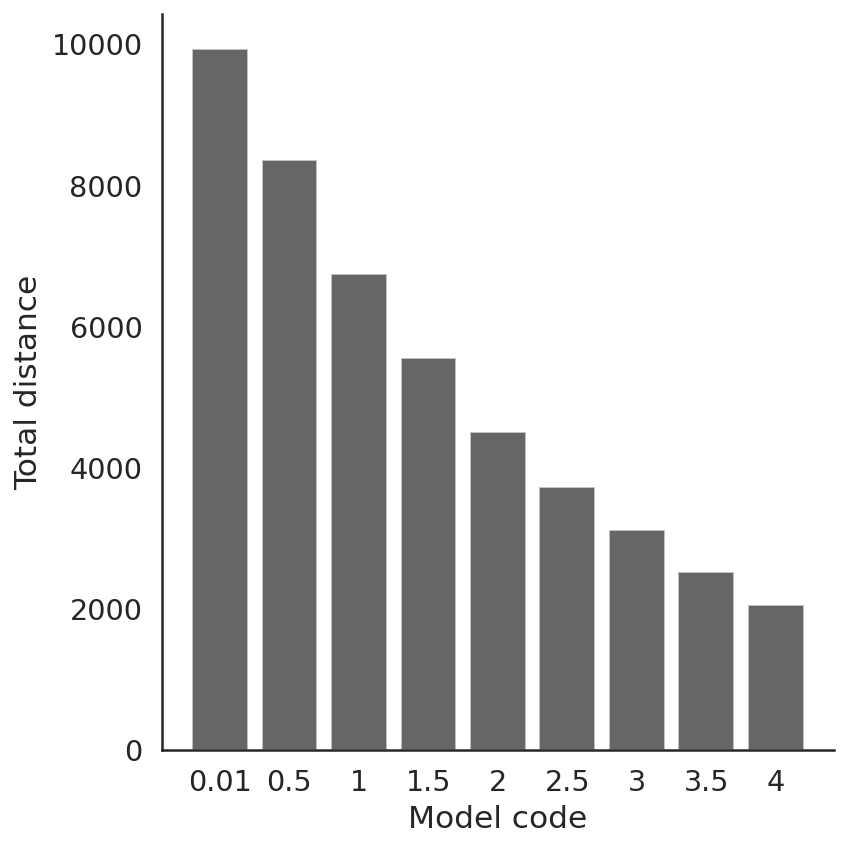

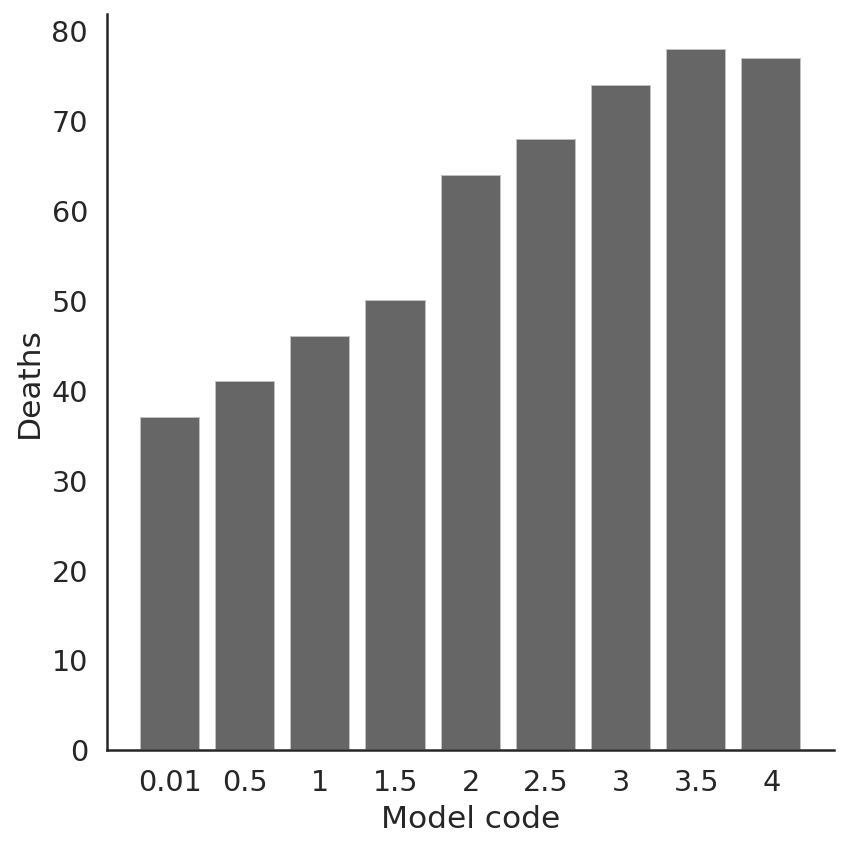

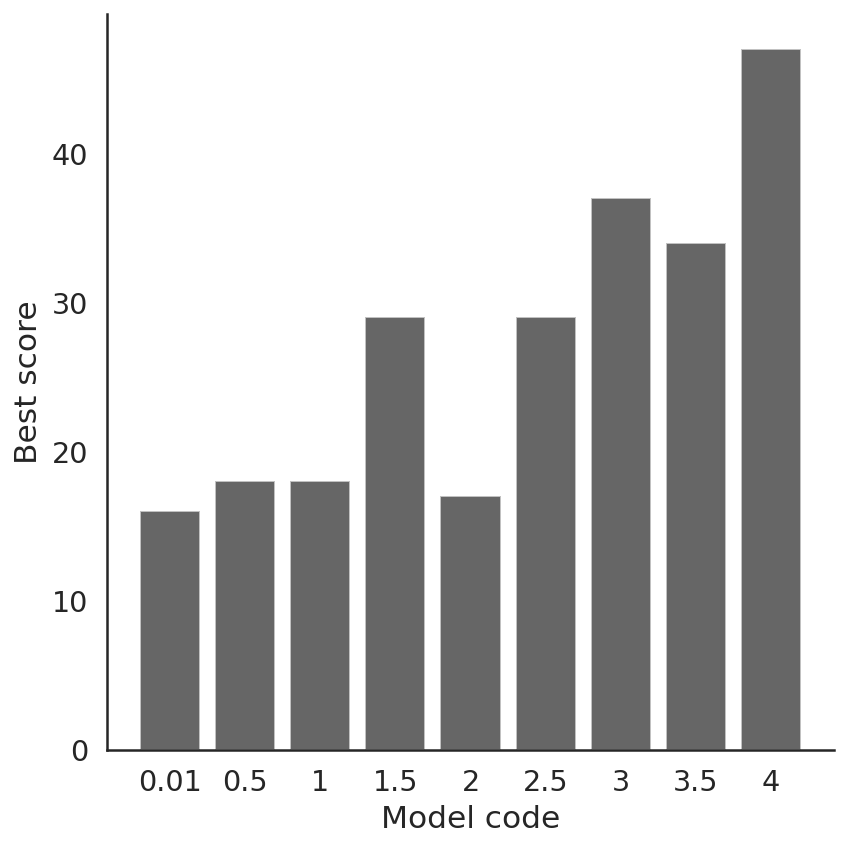

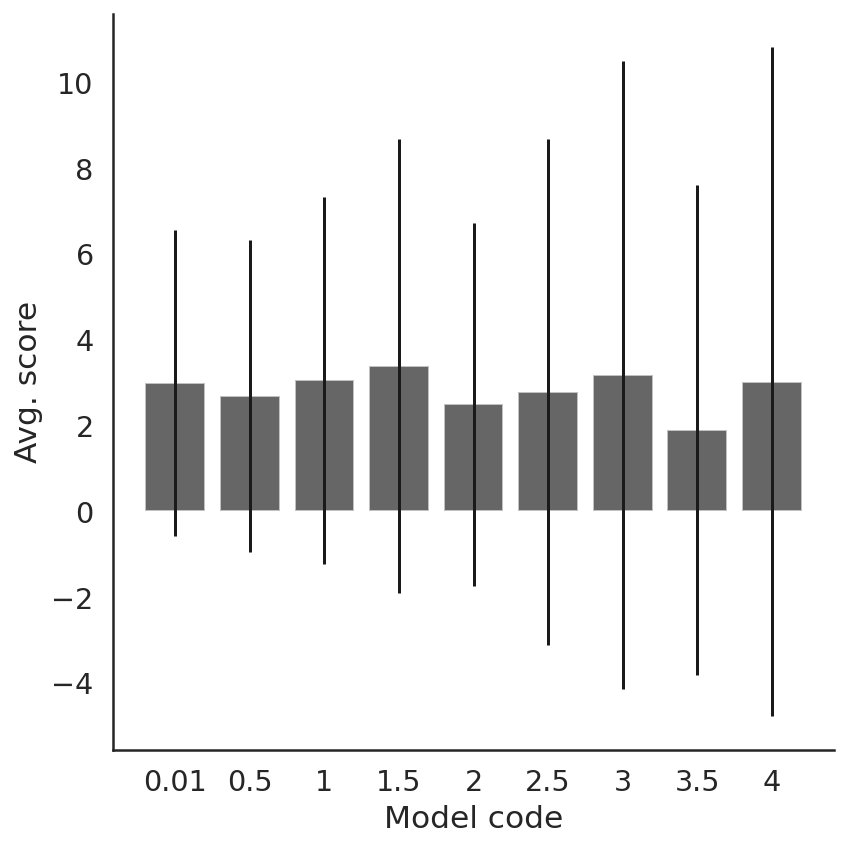

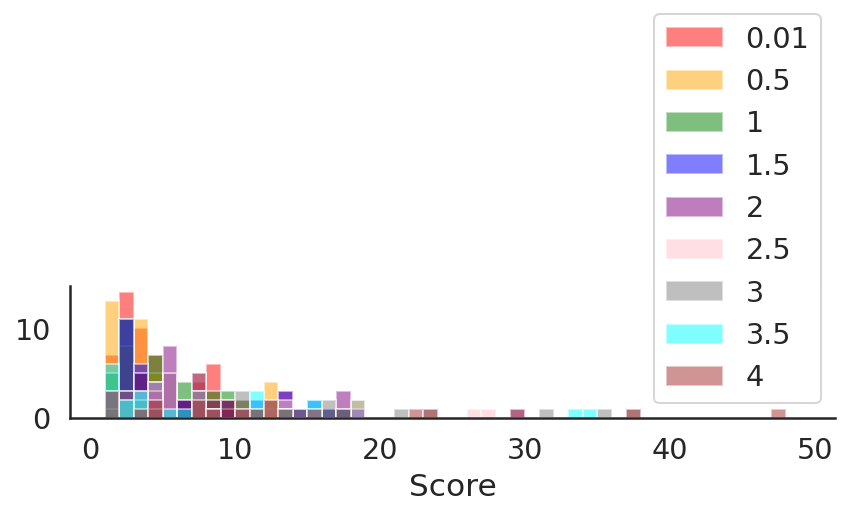

In [ ]:
plot_boundary = (25, 25)
num_experiment = 0
ax = None
for i, result, color in zip(names, results, colors):
    ax = plot_position2d(
        select_exp(result, num_experiment),
        boundary=plot_boundary,
        label=i,
        color=color,
        alpha=1,
        ax=ax,
    )
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

# Score
scores = []
for result in results:  
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(6, 6))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(6, 6))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(6, 6))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 6))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()


### Question 1 [15 pts]

Based on the plots above and in your own words, summarize the relationship between the decision _threshold_ and the total distance, number of deaths, best reward and average reward.  How do the effects of increasing threshold compare to the effects of increasing drift rate (from the example in lab)?

Specifically looking at `threshold`, as threshold increased in value, the total distance travelled decreased, the total amount of deaths increased, and the best score achieved increased. These observations were the opposite when analyzing the effect of increasing drift rate. *Very crudly speaking*, there seems to be an inverse/negative relationship between `threshold` and `drift_rate`.

Regarding `Avg. Score`, the total amount of variance in `Avg. Score` increased as the threshold increased, however the average scores between all groups remained fairly comparable between a very low threshold (0.01) and a relatively large one (4.0).

### Question 2 [10 pts]

Based on your observations, do you think an accumulator is needed for this *particular* task setup?  Would you expect an agent which doesn't accumulate (having a threshold of almost zero, thus reacting immediately to its first sensory signal) to outform an agent which uses multiple time steps to accumulate evidence?

I don't think an accumulator is necessary. If you take a look at lower threshold values, they have higher surivial rates compared to the higher threshold agents as well as comprable average scores. There doesn't seem to be  much benefit when it comes to higher threshold values thus I would conclude that they are not needed.

With that being said, I don't think an agent with no accumulator will out preform an agent that uses multiple time steps to accumulate evidence. An agent that uses multiple time steps will achieve better scores since it makes decisions based on an accumulation of evidence that suggests whether or not the agent will be rewarded. Compared to the former agent, an agent that rolls the dice without thinking/evidence, an agent which uses multiple time steps to accumulate evidence should intuitively outpreform the choas of randomness. 


### Question 3 [5 pts]

Let's get philosophical. Is it better to gamble on being the best, knowing you risk death (in this task) or is it better to be average and alive? 

Based on the data from lab and this homework, what DDM parameters (drift rate, decision threshold) do you _personally_ prefer? There is no right answer. Be yourself.

I'll preface this by saying that I have somewhat of a gambling problem while also being capable of limiting my exposure to too much risk. With that being said, I'd prefer a decision threshold of 3.0 and a drift rate of 1.0 as that sort of matches the profile in my preface. There is certainly risk involved, but just enough that I'm not over-exposed with a high potential of upside/reward. 

## Section - Is randomness still important for movement? [40 pts total]

Let's take a break from evidence accumulation to revisit the simpler sniffing agent, which automatically knows the gradient direction without having to decide first.

Recall that the movement of these sniffing agents is also governed by two other parameters: _p pos_ and _p neg_.  These represent the probability that the agent changes its direction before its linear movement.

- If the gradient is positive at the current location, then _p pos_ is the chance of changing direction.
- If the gradient is negative, then _p neg_ is the chance of changing direction.

### Question 4 [10 pts]
In the example in lab, _p pos_ was 0.5, and _p neg_ was 1.0. This means that when the gradient was positive half the time the walker would change direction anyway. It also means the all the time when the grad was negative, the explorer would change direction.

Do these parameter choices seem optimal to you? 

Make a best guess for how to improve them, if you think they can be improved. Explain your choice.

`p neg` seems optimal here since if the gradient is negative then you would want to switch directions. However, it doesn't make too much sense to change directions if the gradient were positive, you wouldn't want to change directions. I'd lower `p pos` to 0.1 since this significantly reduces the chance that it would change direction but still leaves a slight opportunity for it to change. 

### Testing your hypothesis [15 pts]

By (very slightly) modifying the parameters of the code from lab, rerun the comparison between diffusion, levy, and sniffing agents, but with a better selection for _p pos_ and _p neg_.  Then plot the results.

test4_levy:   0%|          | 0/100 [00:00<?, ?it/s]

test4_diff:   0%|          | 0/100 [00:00<?, ?it/s]

test4_sniff:   0%|          | 0/100 [00:00<?, ?it/s]

Levy - 1.0
Diff - 0.0
Sniff - 20.0


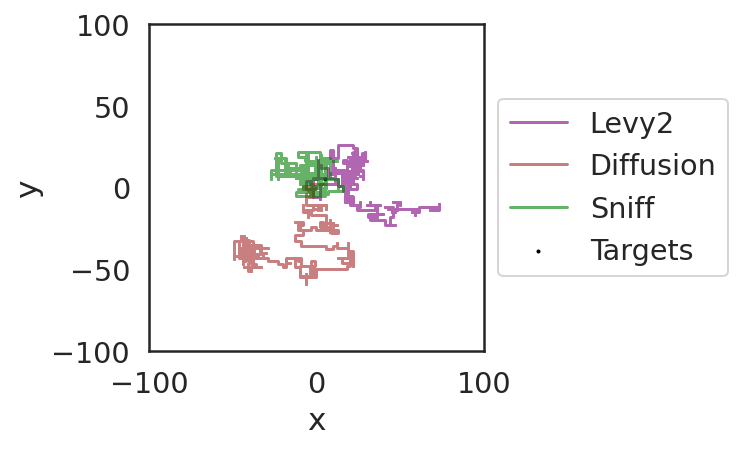

In [ ]:
# Experiment settings
num_experiments = 100
num_steps = 1000
p_neg = 1
p_pos = 0.1
scent_sigma = 10

# Env
detection_radius = 1
min_length = 1
max_length = 10

env = ScentGrid(mode="discrete")
boundary = (100, 100)
target = (5,5)
coord, scent = create_grid_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# Run Sims
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
) 

print(f'Levy - {np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"])}')
print(f'Diff - {np.sum(select_exp(diff_exp, num_experiment)["exp_reward"])}')
print(f'Sniff - {np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"])}')

### Question 5 [10 pts]

Was your hypothesis correct? Compare the scores to those achieved in lab.

I'd say so since reducing `p pos` significantly increased the reward obtained by the sniffing agent. For reference, the result I got in the lab was 3 and in this test the score I recieved was a 20. That's almost a 7x increase in score.

### Question 6 [5 pts]

Can you imagine a situation in which setting _p pos_ to zero would be bad?  As in, could there exist an environment in which always strictly following the scent gradient is suboptimal? Use your imagination.

With regard to `p pos` = 0 being suboptimal, the only thing I can think of is an enviroment that includes obstacles and predators. Both of these variables would hinder the agents success if `p pos` = 0 since you would typically want to avoid obstacles / predators. 

## Submission

**DUE:** 5pm EST, Oct 12, 2021. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*